# Keras Text Classification
This a text classification example for Reuters news corpus.
* *W2V* denotes use of pre-trained Word2Vec embedding built on full Wikipedia dump
* *Masking* denotes use of making mechanism which ignores padded values

In [1]:
import time
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf

import keras.backend as K
from keras.datasets import reuters
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Masking, LSTM, Convolution1D, MaxPooling1D, Flatten, Dropout
from keras.layers.pooling import _GlobalPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback
from keras.optimizers import TFOptimizer

from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Set style

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Just for the sake of reproducibility

In [3]:
np.random.seed(21)

General pipeline:
* Data:
    * Download
    * Split
    * Truncate/Pad sentences to equal lengths
* Models:
    * Linear / No Masking / Pre-trained embedding
    * Linear / Masking / Pre-trained embedding
    * MLP / Masking / Pre-trained embedding
    * Linear / Masking / No pre-trained embedding
    * FastText

Table of results for Reuters expetiments

In [4]:
results = pd.DataFrame(columns=["Model", "Masking", "Embedding", "Accuracy train, %", "Accuracy test, %", "Train Time, s"])
results

,Model,Masking,Embedding,"Accuracy train, %","Accuracy test, %","Train Time, s"


# EDA Reuters

Download data

In [5]:
!wget https://s3.amazonaws.com/text-datasets/reuters.pkl -O ./reuters.pkl

--2017-10-21 14:28:21--  https://s3.amazonaws.com/text-datasets/reuters.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.224.243
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.224.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9211982 (8.8M) [application/octet-stream]
Saving to: './reuters.pkl'

./reuters.pkl       100%[===================>]   8.79M  2.18MB/s    in 4.0s    

2017-10-21 14:28:26 (2.18 MB/s) - './reuters.pkl' saved [9211982/9211982]



In [6]:
with open("./reuters.pkl", 'rb') as f:
    X, y = pickle.load(f)

Train/Test split in *stratified* (preserves the distribution across classes) manner in fraction of $4/1$.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(len(X_train), 'train sequences')
print(len(X_valid), 'test sequences')

8982 train sequences
2246 test sequences


In [8]:
n_classes = np.max(y_train) + 1
print(n_classes, 'classes')

46 classes


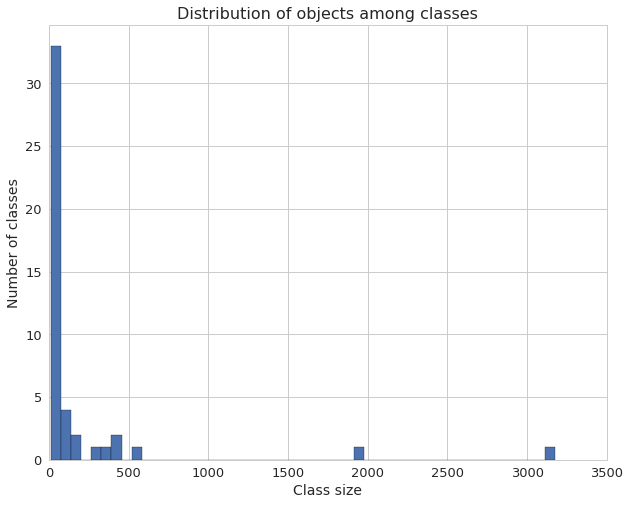

In [9]:
plt.hist(np.unique(y_train, return_counts=True)[1], bins=50, edgecolor="k")
plt.xlabel("Class size", fontsize=14)
plt.ylabel("Number of classes", fontsize=14)
plt.title("Distribution of objects among classes", fontsize=16)
plt.xlim([0, 3500]);

In [10]:
number_of_words = np.max(list(map(lambda x: np.max(x), X_train)))
print("Total number of words:", number_of_words)

Total number of words: 30979


Now let's embed our words into low-dimensional space using pre-trained (Full English Wiki dump) Word2Vec embedding

Pre-trained embedding can be found [here](https://www.dropbox.com/s/9pu6mt769kj8803/pretrained_embedding.tar.gz?dl=0)

In [11]:
!wget https://www.dropbox.com/s/9pu6mt769kj8803/pretrained_embedding.tar.gz
!tar -xvzf pretrained_embedding.tar.gz

--2017-10-21 14:28:28--  https://www.dropbox.com/s/9pu6mt769kj8803/pretrained_embedding.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/sahoeECfAgOJWVF0TZphSxTAfnx7s1uMNudYiLxsakZIRRGmGO6Lhw2440HPBlsz/file [following]
--2017-10-21 14:28:28--  https://dl.dropboxusercontent.com/content_link/sahoeECfAgOJWVF0TZphSxTAfnx7s1uMNudYiLxsakZIRRGmGO6Lhw2440HPBlsz/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6, 2620:100:6022:6::a27d:4206
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 866689471 (827M) [application/octet-stream]
Saving to: 'pretrained_embedding.tar.gz'

pretrained_embeddin 100%[===================>] 826.54M  5

In [12]:
embeddings_index = {}
f = open("./wiki_w2v.vec")
f.readline()
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
EMBEDDING_DIM = len(embeddings_index["the"])
print("Embedding dimension is", EMBEDDING_DIM)

Embedding dimension is 100


Example of word-vector

In [14]:
print("\"the\"\n", embeddings_index["the"])

"the"
 [-0.139744    0.20813    -0.118162    0.061692   -0.002767    0.19353899
 -0.137596   -0.081763    0.10003    -0.023349   -0.35396001 -0.086922
 -0.10971     0.14912     0.24900199  0.090235   -0.175136    0.100408
  0.227097   -0.38284701  0.20857599  0.203307   -0.060234    0.137311
  0.100868   -0.005166   -0.06901    -0.29135701 -0.077014    0.077363
 -0.67388499  0.33003101 -0.32567599 -0.003312   -0.069184   -0.016198
 -0.20462    -0.01192     0.105787    0.039009    0.38602901  0.014063
 -0.34556401 -0.185229   -0.19212601 -0.051685   -0.055161   -0.279562
 -0.31859699 -0.17527901  0.223395   -0.40426299  0.030896   -0.27991199
 -0.018625   -0.072526    0.0099      0.31887901  0.26463899 -0.157149
 -0.41845399  0.030546    0.30279899  0.126863    0.057413   -0.278595
 -0.49134201 -0.37145299  0.37209201 -0.18141     0.34714001  0.076957
 -0.20196401 -0.257523    0.095072    0.019826   -0.176595    0.39072999
  0.165888    0.17529801 -0.37434199 -0.088488    0.097903   -0.

Select only those word-vectors from pre-trained model that are in our vocabulary

In [15]:
embedding_matrix = np.zeros((number_of_words + 1, EMBEDDING_DIM))
for word, i in reuters.get_word_index().items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

524288/550378 [===========================>..] - ETA: 0s

Let's also see what is the distribution of sentences lengths

In [16]:
sentences_lengths_distribution = list(map(lambda sen: len(sen), X_train))

In [17]:
MAX_SEQUENCE_LENGTH = np.max(sentences_lengths_distribution)
MEAN_SEQUENCE_LENGTH = np.mean(sentences_lengths_distribution)
print("Maximum sentence length:", MAX_SEQUENCE_LENGTH)
print("Mean sentence length:", np.round(MEAN_SEQUENCE_LENGTH, 2))
print("95% percentile of sentence lengths:", np.round(np.percentile(sentences_lengths_distribution, 95), 2))

Maximum sentence length: 2375
Mean sentence length: 144.72
95% percentile of sentence lengths: 458.0


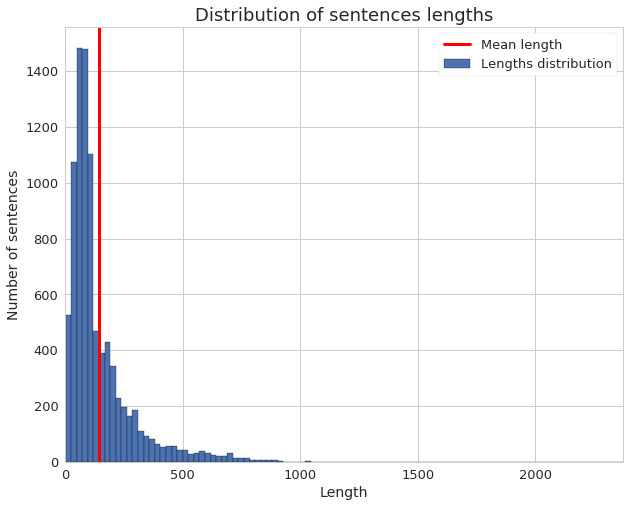

In [18]:
plt.hist(sentences_lengths_distribution, bins=100, label="Lengths distribution", edgecolor="k")
plt.xlim([0, MAX_SEQUENCE_LENGTH])
ylims = plt.ylim()
plt.plot([MEAN_SEQUENCE_LENGTH, MEAN_SEQUENCE_LENGTH], [ylims[0], ylims[1]], c="r", lw=3, label="Mean length")
plt.ylim([ylims[0], ylims[1]])
plt.xlabel("Length", fontsize=14)
plt.ylabel("Number of sentences", fontsize=14)
plt.title("Distribution of sentences lengths", fontsize=18)
plt.legend();

Let's truncate (or pad) all the sentences to some reasonable length. Padding is done with zeros from the beginning of the sentence and truncating is done from the end.

In [19]:
MAX_SEQUENCE_LENGTH = 400

In [20]:
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_valid = pad_sequences(X_valid, maxlen=MAX_SEQUENCE_LENGTH)

Let's also one-hot encode our labels

In [21]:
print('Convert class vector to binary class matrix (for use with categorical_crossentropy)')
y_train = np_utils.to_categorical(y_train, n_classes)
y_valid = np_utils.to_categorical(y_valid, n_classes)
print('Y_train shape:', y_train.shape)
print('Y_test shape:', y_valid.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
Y_train shape: (8982, 46)
Y_test shape: (2246, 46)


# Models

All models follow the following logic:
* Embed all word into vectors
* Average them
* Classify one averaged vector

## Softmax Classifier: No masking, W2V

Remember we padded short sentences with zeros. We should not consider them while averaging word vectors. For that purpose the masks are used which tell where is the real input and where is the padded values. 

By default Keras does not support masking for averaging layer. Let's try default model first.

Input layer

In [22]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                       dtype='int32', 
                       name="Input")

Embed each word of input sentence. Here we want to use pre-trained embedding downloaded before and do not want to train them ($\text{trainable = False}$). Also we do not want to use masking ($\text{mask_zero=False}$)

In [23]:
embedded_sequences = Embedding(input_dim=number_of_words + 1,
                               output_dim=EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False,
                               mask_zero=False, 
                               name="Embedding")(sequence_input)

Average word vectors

In [24]:
averaged = GlobalAveragePooling1D()(embedded_sequences)

Multinomial Logistic Regression classifier on top of averaged vectors

In [25]:
output = Dense(n_classes, activation="softmax")(averaged)

Build and compile model

In [26]:
model_lin_no_mask = Model(inputs=[sequence_input], outputs=[output])

In [27]:
model_lin_no_mask.compile(loss='categorical_crossentropy',
                          optimizer='nadam',
                          metrics=['accuracy'])
model_lin_no_mask.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 400)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 400, 100)          3098000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                4646      
Total params: 3,102,646
Trainable params: 4,646
Non-trainable params: 3,098,000
_________________________________________________________________


Train model. Here we define simple callback to trace how many epochs have been done (default output is too long for 100 epochs)

In [28]:
class trace_callback(Callback):
    def __init__(self, freq = 10):
        self.freq = freq
    
    def on_epoch_end(self, epoch, logs={}):
        if (epoch + 1) % self.freq == 0:
            print("Epoch " + str(epoch + 1) + " end")

In [29]:
%%time
start_lin_no_mask = time.time()
trace = trace_callback()
history_lin_no_mask = model_lin_no_mask.fit(X_train, y_train,
                                            epochs=100, 
                                            batch_size=32,
                                            validation_data=(X_valid, y_valid), 
                                            verbose=0, 
                                            callbacks=[trace])
end_lin_no_mask= time.time()

Epoch 10 end
Epoch 20 end
Epoch 30 end
Epoch 40 end
Epoch 50 end
Epoch 60 end
Epoch 70 end
Epoch 80 end
Epoch 90 end
Epoch 100 end
CPU times: user 2min 43s, sys: 35.3 s, total: 3min 18s
Wall time: 1min 28s


Training evolution

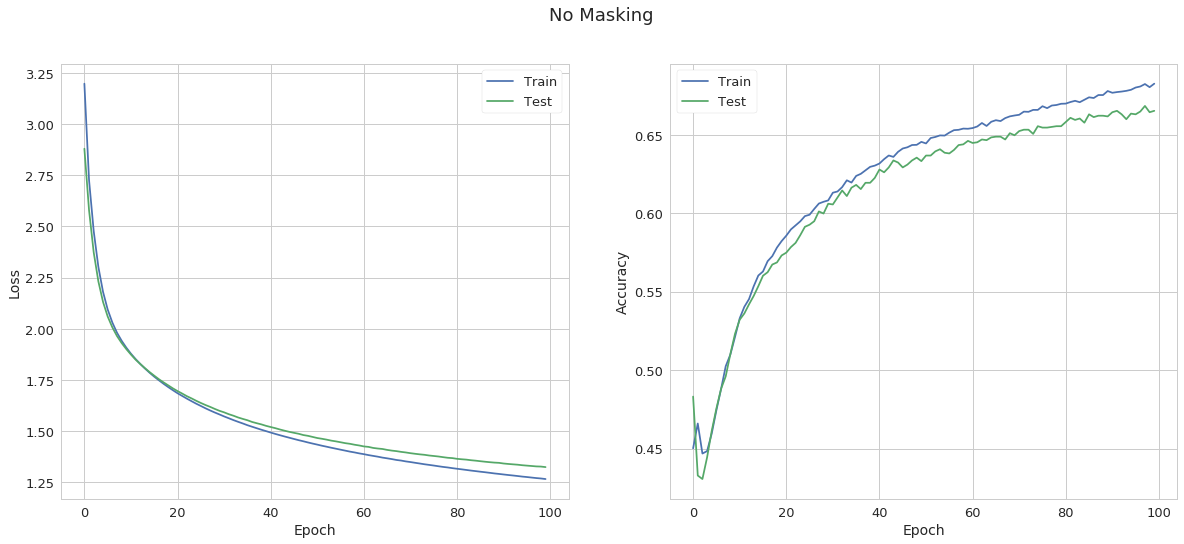

In [30]:
plt.figure(figsize=(20, 8))
plt.suptitle("No Masking", fontsize=18)
plt.subplot(121)
plt.plot(history_lin_no_mask.history["loss"], label="Train")
plt.plot(history_lin_no_mask.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(history_lin_no_mask.history["acc"], label="Train")
plt.plot(history_lin_no_mask.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14);

Results

In [31]:
results.loc[len(results)] = ["Softmax", 
                             "No",  
                             "W2V Full Wiki", 
                             np.round(history_lin_no_mask.history["acc"][-1] * 100, 1), 
                             np.round(history_lin_no_mask.history["val_acc"][-1] * 100, 1), 
                             np.round(end_lin_no_mask - start_lin_no_mask, 1)]

In [32]:
results

,Model,Masking,Embedding,"Accuracy train, %","Accuracy test, %","Train Time, s"
0,Softmax,No,W2V Full Wiki,68.2,66.5,88.2


## Softmax Classifier: Masking, W2V

Now let's redefine averaging layer in a way that it supports masking

In [33]:
class MaskedGlobalAveragePooling1D(_GlobalPooling1D):
    
    def __init__(self, **kwargs):
        self.support_mask = True
        super(MaskedGlobalAveragePooling1D, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaskedGlobalAveragePooling1D, self).build(input_shape)
        self.feat_dim = input_shape[2]

    def call(self, x, mask=None):
        if mask is not None:
            mask = K.cast(mask, 'float32')
            n = K.sum(mask, axis=-1, keepdims=True)
            n += K.ones_like(n) * K.cast(K.equal(n, 0.0), 'float32')
            ans = K.sum(x, axis=1) / n
        else:
            ans = K.mean(x, axis=1)
        
        return ans

    def compute_mask(self, input_shape, input_mask=None):
        return None

Input layer

In [34]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                       dtype='int32', 
                       name="Input")

Embed each word of input sentence. Here we want to use pre-trained embedding downloaded before and do not want to train them ($\text{trainable = False}$). Now we do want to use masking ($\text{mask_zero=True}$)

In [35]:
embedded_sequences = Embedding(input_dim=number_of_words + 1,
                               output_dim=EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False,
                               mask_zero=True, 
                               name="Embedding")(sequence_input)

Average word vectors

In [36]:
averaged = MaskedGlobalAveragePooling1D()(embedded_sequences)

Multinomial Logistic Regression classifier on top of averaged vectors

In [37]:
output = Dense(n_classes, activation="softmax")(averaged)

Build and compile model

In [38]:
model_lin_masked = Model(inputs=[sequence_input], outputs=[output])

In [39]:
model_lin_masked.compile(loss='categorical_crossentropy',
                         optimizer='nadam',
                         metrics=['accuracy'])
model_lin_masked.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 400)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 400, 100)          3098000   
_________________________________________________________________
masked_global_average_poolin (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                4646      
Total params: 3,102,646
Trainable params: 4,646
Non-trainable params: 3,098,000
_________________________________________________________________


Train model. Here we use simple callback (defined before) to trace how many epochs have been done (default output is too long for 100 epochs)

In [40]:
%%time
start_lin_masked = time.time()
trace = trace_callback()
history_lin_masked = model_lin_masked.fit(X_train, y_train,
                                          epochs=100, 
                                          batch_size=32,
                                          validation_data=(X_valid, y_valid), 
                                          verbose=0, 
                                          callbacks=[trace])
end_lin_masked = time.time()

Epoch 10 end
Epoch 20 end
Epoch 30 end
Epoch 40 end
Epoch 50 end
Epoch 60 end
Epoch 70 end
Epoch 80 end
Epoch 90 end
Epoch 100 end
CPU times: user 3min 29s, sys: 49.1 s, total: 4min 18s
Wall time: 1min 47s


Training evolution

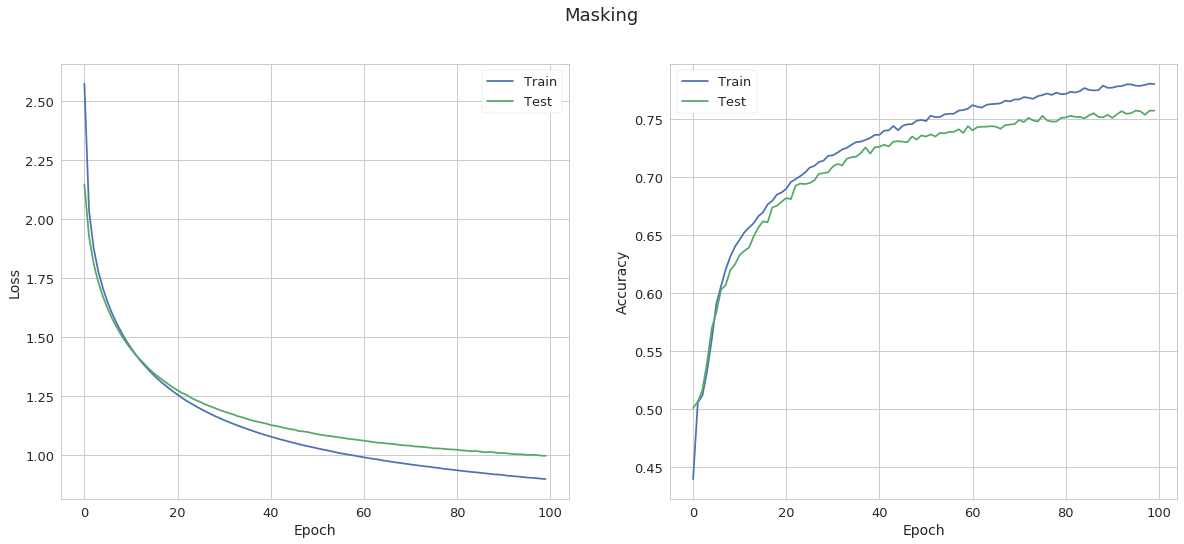

In [41]:
plt.figure(figsize=(20, 8))
plt.suptitle("Masking", fontsize=18)
plt.subplot(121)
plt.plot(history_lin_masked.history["loss"], label="Train")
plt.plot(history_lin_masked.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(history_lin_masked.history["acc"], label="Train")
plt.plot(history_lin_masked.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14);

Results

In [42]:
results.loc[len(results)] = ["Softmax", 
                             "Yes", 
                             "W2V Full Wiki",
                             np.round(history_lin_masked.history["acc"][-1] * 100, 1), 
                             np.round(history_lin_masked.history["val_acc"][-1] * 100, 1), 
                             np.round(end_lin_masked - start_lin_masked, 1)]

In [43]:
results

,Model,Masking,Embedding,"Accuracy train, %","Accuracy test, %","Train Time, s"
0,Softmax,No,W2V Full Wiki,68.2,66.5,88.2
1,Softmax,Yes,W2V Full Wiki,78.0,75.7,107.8


Waaay to better then without masking!!

## MLP Classifier: Masking, W2V

Now let's try to make our model a bit more complex - add one more intermediate fully-connected layer

Input layer

In [44]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                       dtype='int32', 
                       name="Input")

Embed each word of input sentence. Here we want to use pre-trained embedding downloaded before and do not want to train them ($\text{trainable = False}$). Now we do want to use masking ($\text{mask_zero=True}$)

In [45]:
embedded_sequences = Embedding(input_dim=number_of_words + 1,
                               output_dim=EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False,
                               mask_zero=True, 
                               name="Embedding")(sequence_input)

Average word vectors

In [46]:
averaged = MaskedGlobalAveragePooling1D()(embedded_sequences)

Additional FC layers + Softmax Classifier

In [47]:
fc = Dense(64, activation="relu")(averaged)
output = Dense(46, activation="softmax")(fc)

Build and compile model

In [48]:
model_fc = Model(inputs=[sequence_input], outputs=[output])

In [49]:
model_fc.compile(loss='categorical_crossentropy',
                 optimizer='nadam',
                 metrics=['accuracy'])
model_fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 400)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 400, 100)          3098000   
_________________________________________________________________
masked_global_average_poolin (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_4 (Dense)              (None, 46)                2990      
Total params: 3,107,454
Trainable params: 9,454
Non-trainable params: 3,098,000
_________________________________________________________________


Train model. Here we use simple callback (defined before) to trace how many epochs have been done (default output is too long for 100 epochs)

In [50]:
%%time
start_fc = time.time()
trace = trace_callback()
history_fc = model_fc.fit(X_train, y_train,
                          epochs=100, 
                          batch_size=32,
                          validation_data=(X_valid, y_valid), 
                          verbose=0, 
                          callbacks=[trace])
end_fc = time.time()

Epoch 10 end
Epoch 20 end
Epoch 30 end
Epoch 40 end
Epoch 50 end
Epoch 60 end
Epoch 70 end
Epoch 80 end
Epoch 90 end
Epoch 100 end
CPU times: user 3min 57s, sys: 52.9 s, total: 4min 50s
Wall time: 2min 8s


Training Evolution

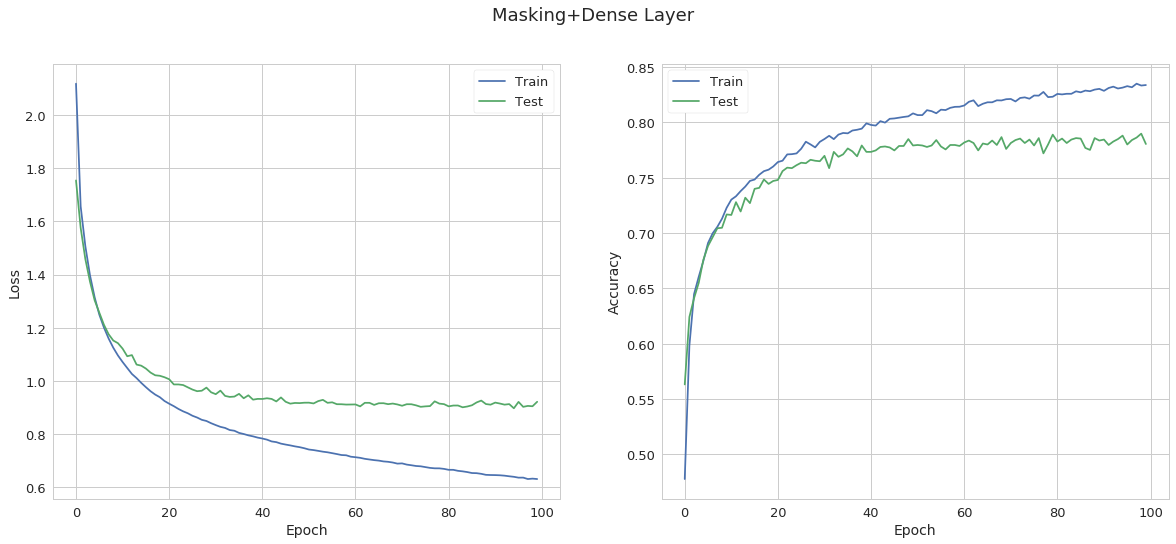

In [51]:
plt.figure(figsize=(20, 8))
plt.suptitle("Masking+Dense Layer", fontsize=18)
plt.subplot(121)
plt.plot(history_fc.history["loss"], label="Train")
plt.plot(history_fc.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(history_fc.history["acc"], label="Train")
plt.plot(history_fc.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14);

Results

In [52]:
results.loc[len(results)] = ["MLP", 
                             "Yes",  
                             "W2V Full Wiki",
                             np.round(history_fc.history["acc"][-1] * 100, 1), 
                             np.round(history_fc.history["val_acc"][-1] * 100, 1), 
                             np.round(end_fc - start_fc, 1)]

In [53]:
results

,Model,Masking,Embedding,"Accuracy train, %","Accuracy test, %","Train Time, s"
0,Softmax,No,W2V Full Wiki,68.2,66.5,88.2
1,Softmax,Yes,W2V Full Wiki,78.0,75.7,107.8
2,MLP,Yes,W2V Full Wiki,83.4,78.0,128.8


Even better then simple linear classifier!

## Softmax Classifier: Masking, No W2V

Now let's try to learn embeddings from scratch

Input layer

In [54]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                       dtype='int32', 
                       name="Input")

Embed each word of input sentence. Here we do not want to use pre-trained embedding. Now we do want to use masking ($\text{mask_zero=True}$)

In [55]:
embedded_sequences = Embedding(input_dim=number_of_words + 1,
                               output_dim=EMBEDDING_DIM,
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=True,
                               mask_zero=True, 
                               name="Embedding")(sequence_input)

Average word vectors

In [56]:
averaged = MaskedGlobalAveragePooling1D()(embedded_sequences)

Multinomial Logistic Regression classifier on top of averaged vectors

In [57]:
output = Dense(n_classes, activation="softmax")(averaged)

Build and compile model

In [58]:
model_no_emb = Model(inputs=[sequence_input], outputs=[output])

Here we need to train the whole embedding. Notice that the input to the embedding layer is extremely sparse matrix (sequence of one-hot-encoded words). Keras optimizer works [slow](https://github.com/fchollet/keras/issues/4365) with sparse matrices while `TFOptimizer` can handle them in more sensible way.

In [59]:
model_no_emb.compile(loss='categorical_crossentropy',
                     optimizer=TFOptimizer(tf.train.AdamOptimizer()),
                     metrics=['accuracy'])
model_no_emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 400)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 400, 100)          3098000   
_________________________________________________________________
masked_global_average_poolin (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 46)                4646      
Total params: 3,102,646
Trainable params: 3,102,646
Non-trainable params: 0
_________________________________________________________________


Train model. Here we use simple callback (defined before) to trace how many epochs have been done (default output is too long for 100 epochs)

In [60]:
%%time
start_no_emb = time.time()
trace = trace_callback()
history_no_emb = model_no_emb.fit(X_train, y_train,
                                 epochs=100, 
                                 batch_size=32,
                                 validation_data=(X_valid, y_valid), 
                                 verbose=0, 
                                 callbacks=[trace])
end_no_emb = time.time()

Epoch 10 end
Epoch 20 end
Epoch 30 end
Epoch 40 end
Epoch 50 end
Epoch 60 end
Epoch 70 end
Epoch 80 end
Epoch 90 end
Epoch 100 end
CPU times: user 4min 52s, sys: 54.6 s, total: 5min 46s
Wall time: 2min 30s


Training Evolution

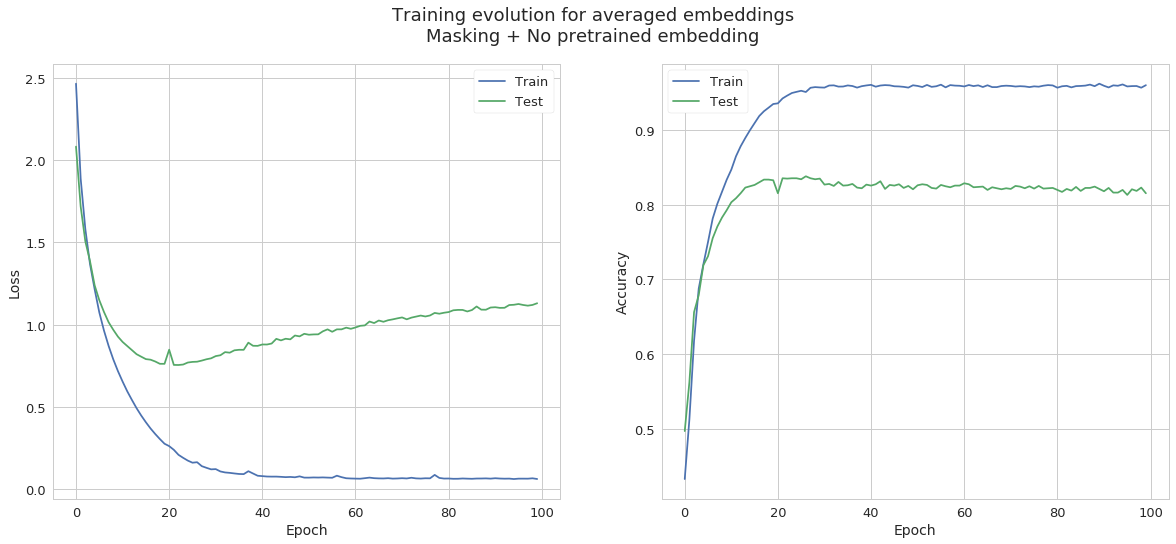

In [61]:
plt.figure(figsize=(20, 8))
plt.suptitle("Training evolution for averaged embeddings\nMasking + No pretrained embedding", fontsize=18)
plt.subplot(121)
plt.plot(history_no_emb.history["loss"], label="Train")
plt.plot(history_no_emb.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(history_no_emb.history["acc"], label="Train")
plt.plot(history_no_emb.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

Results

In [62]:
results.loc[len(results)] = ["Softmax", 
                             "Yes", 
                             "None",
                             np.round(history_no_emb.history["acc"][-1] * 100, 1), 
                             np.round(history_no_emb.history["val_acc"][-1] * 100, 1), 
                             np.round(end_no_emb - start_no_emb, 1)]

In [63]:
results

,Model,Masking,Embedding,"Accuracy train, %","Accuracy test, %","Train Time, s"
0,Softmax,No,W2V Full Wiki,68.2,66.5,88.2
1,Softmax,Yes,W2V Full Wiki,78.0,75.7,107.8
2,MLP,Yes,W2V Full Wiki,83.4,78.0,128.8
3,Softmax,Yes,None,96.0,81.5,151.0


2% Better!

## CNN: No masking, W2V

In [64]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                       dtype='int32', 
                       name="Input")

In [65]:
embedded_sequences = Embedding(input_dim=number_of_words + 1,
                               output_dim=EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False,
                               mask_zero=False,
                               name="Embedding")(sequence_input)

In [66]:
x = Convolution1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Convolution1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(n_classes, activation='softmax')(x)

In [67]:
model_cnn = Model(inputs=[sequence_input], outputs=[output])

In [68]:
model_cnn.compile(loss='categorical_crossentropy', 
                  optimizer='nadam',  
                  metrics=['accuracy'])
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 400)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 400, 100)          3098000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 132, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

In [69]:
%%time
start_cnn = time.time()
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=10, 
                            batch_size=32,
                            validation_data=(X_valid, y_valid), 
                            verbose=1)
end_cnn = time.time()

Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 4s - loss: 1.7773 - acc: 0.5586 - val_loss: 1.4049 - val_acc: 0.6465
Epoch 2/10
8982/8982 [==============================] - 2s - loss: 1.2272 - acc: 0.6938 - val_loss: 1.1488 - val_acc: 0.7195
Epoch 3/10
8982/8982 [==============================] - 2s - loss: 0.9947 - acc: 0.7450 - val_loss: 1.0886 - val_acc: 0.7400
Epoch 4/10
8982/8982 [==============================] - 2s - loss: 0.7971 - acc: 0.7890 - val_loss: 1.0531 - val_acc: 0.7511
Epoch 5/10
8982/8982 [==============================] - 2s - loss: 0.6196 - acc: 0.8299 - val_loss: 1.0870 - val_acc: 0.7484
Epoch 6/10
8982/8982 [==============================] - 2s - loss: 0.4734 - acc: 0.8707 - val_loss: 1.1531 - val_acc: 0.7703
Epoch 7/10
8982/8982 [==============================] - 2s - loss: 0.3956 - acc: 0.8959 - val_loss: 1.1858 - val_acc: 0.7783
Epoch 8/10
8982/8982 [==============================] - 2s - loss: 0.3179 - a

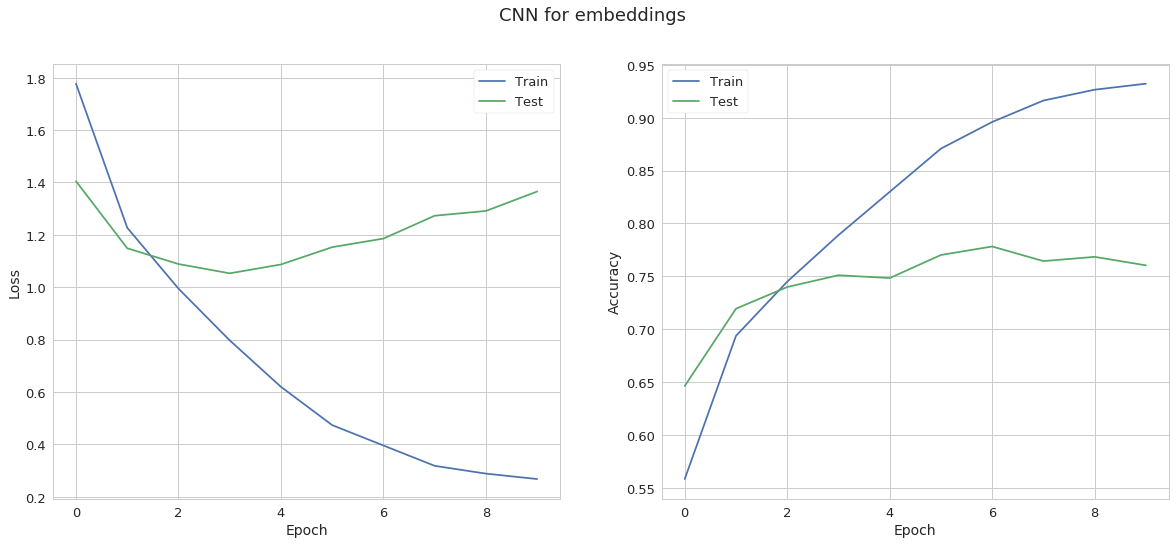

In [70]:
plt.figure(figsize=(20, 8))
plt.suptitle("CNN for embeddings", fontsize=18)
plt.subplot(121)
plt.plot(history_cnn.history["loss"], label="Train")
plt.plot(history_cnn.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(history_cnn.history["acc"], label="Train")
plt.plot(history_cnn.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14);

In [71]:
results.loc[len(results)] = ["CNN", 
                             "No",  
                             "W2V Full Wiki",
                             np.round(history_cnn.history["acc"][-1] * 100, 1), 
                             np.round(history_cnn.history["val_acc"][-1] * 100, 1), 
                             np.round(end_cnn - start_cnn, 1)]
results

,Model,Masking,Embedding,"Accuracy train, %","Accuracy test, %","Train Time, s"
0,Softmax,No,W2V Full Wiki,68.2,66.5,88.2
1,Softmax,Yes,W2V Full Wiki,78.0,75.7,107.8
2,MLP,Yes,W2V Full Wiki,83.4,78.0,128.8
3,Softmax,Yes,None,96.0,81.5,151.0
4,CNN,No,W2V Full Wiki,93.2,76.0,30.3


## LSTM: Masking, W2V

In [72]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                       dtype='int32', 
                       name="Input")

In [73]:
embedded_sequences = Embedding(input_dim=number_of_words + 1,
                               output_dim=EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False,
                               mask_zero=True, 
                               name="Embedding")(sequence_input)

In [ ]:
recurrent = LSTM(units=128, 
                 return_sequences=True, 
                 name="LSTM1")(embedded_sequences)

In [85]:
recurrent = LSTM(units=128, 
                 return_sequences=False, 
                 name="LSTM2")(recurrent)

In [86]:
dense = Dense(units=512,
              activation='relu', 
              name="Dense")(recurrent)

In [87]:
output = Dense(units=n_classes, 
            activation='softmax', 
            name="Softmax")(dense)

In [88]:
model_rnn = Model(inputs=[sequence_input], outputs=[output])

In [89]:
model_rnn.compile(loss='categorical_crossentropy', 
                  optimizer='nadam', 
                  metrics=['accuracy'])
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 400)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 400, 100)          3098000   
_________________________________________________________________
LSTM1 (LSTM)                 (None, 400, 128)          117248    
_________________________________________________________________
LSTM2 (LSTM)                 (None, 128)               131584    
_________________________________________________________________
Dense (Dense)                (None, 512)               66048     
_________________________________________________________________
Softmax (Dense)              (None, 46)                23598     
Total params: 3,436,478
Trainable params: 338,478
Non-trainable params: 3,098,000
____________________________________________________________

In [90]:
%%time
start_rnn = time.time()
history_rnn = model_rnn.fit(X_train, y_train,
                            epochs=2, 
                            batch_size=64,
                            validation_data=(X_valid, y_valid), 
                            verbose=1)
end_rnn = time.time()

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 8982 samples, validate on 2246 samples
Epoch 1/2
8982/8982 [==============================] - 346s - loss: 2.2863 - acc: 0.4252 - val_loss: 2.0688 - val_acc: 0.4817
Epoch 2/2
8982/8982 [==============================] - 344s - loss: 1.8760 - acc: 0.5102 - val_loss: 1.8483 - val_acc: 0.5116
CPU times: user 21min 55s, sys: 9min, total: 30min 56s
Wall time: 11min 32s


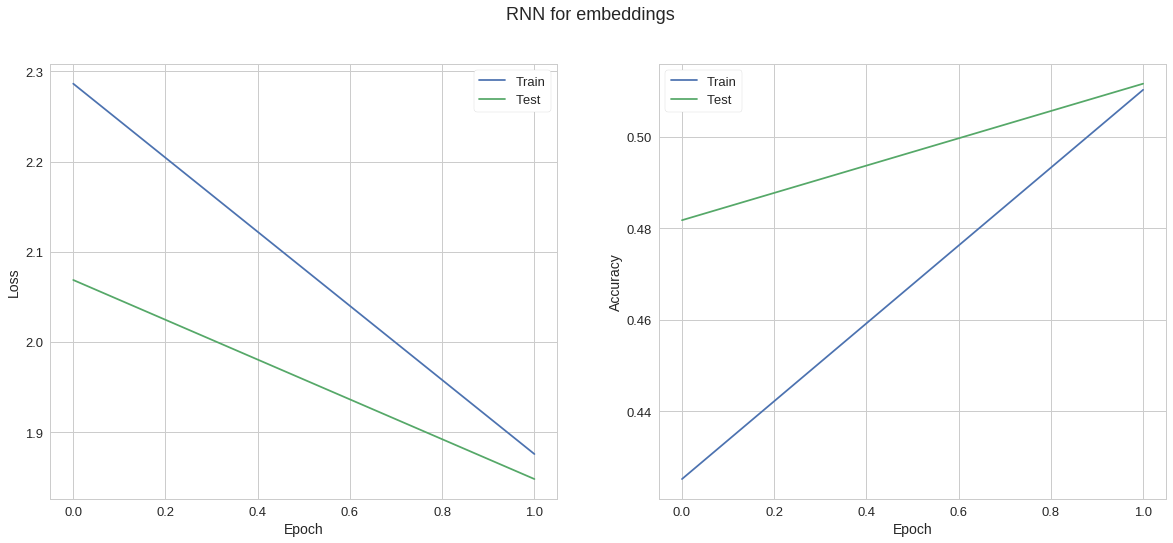

In [91]:
plt.figure(figsize=(20, 8))
plt.suptitle("RNN for embeddings", fontsize=18)
plt.subplot(121)
plt.plot(history_rnn.history["loss"], label="Train")
plt.plot(history_rnn.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(history_rnn.history["acc"], label="Train")
plt.plot(history_rnn.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14);

In [92]:
results.loc[len(results)] = ["RNN", 
                             "Yes", 
                             "W2V Full Wiki",
                             np.round(history_rnn.history["acc"][-1] * 100, 1), 
                             np.round(history_rnn.history["val_acc"][-1] * 100, 1), 
                             np.round(end_rnn - start_rnn, 1)]
results

,Model,Masking,Embedding,"Accuracy train, %","Accuracy test, %","Train Time, s"
0,Softmax,No,W2V Full Wiki,68.2,66.5,134.3
1,Softmax,Yes,W2V Full Wiki,78.0,75.7,138.5
2,MLP,Yes,W2V Full Wiki,83.5,78.2,155.4
3,Softmax,Yes,None,95.9,81.7,210.2
4,CNN,No,W2V Full Wiki,94.0,75.0,86.0
5,RNN,Yes,W2V Full Wiki,51.0,51.2,692.8


# Comparison

In [93]:
results

,Model,Masking,Embedding,"Accuracy train, %","Accuracy test, %","Train Time, s"
0,Softmax,No,W2V Full Wiki,68.2,66.5,134.3
1,Softmax,Yes,W2V Full Wiki,78.0,75.7,138.5
2,MLP,Yes,W2V Full Wiki,83.5,78.2,155.4
3,Softmax,Yes,None,95.9,81.7,210.2
4,CNN,No,W2V Full Wiki,94.0,75.0,86.0
5,RNN,Yes,W2V Full Wiki,51.0,51.2,692.8


# TASK 1: Filter new words in test
Remove new words from test data when training the embedding locally and repotr impact

# TASK 2: Rare words
Try to eliminate words with low frequency (less than 3-7) from corpus. How does it influence the quality?